In [34]:
import numpy as np
import pandas as pd
import configparser
import sys

In [35]:
RiskFreeReturn = 0.05
Volatility = .2
SimulationNumbers = 10000
IntervalsNumber = 10000
MaxIteration = 10000
Precision = 1.0e-8
RandomSeed = 20000
PricesMatrixPath = 'PricesMatrix.csv'
VolatilityMatrixPath = 'VolatilityMatrix.csv'
PricesChartPath = 'PriceChart.png'
VolatilityChartPath = 'VolatilityChart.png'

In [36]:
InitialAssetPrice = 1
MaxTime = 2
MaxStrike = 1.5
TimesArrayIntervals = 10
StrikesArrayIntervals = 10

In [37]:
TimesArray = np.linspace(0.5, MaxTime, TimesArrayIntervals)
StrikeArray = np.linspace(0.5, MaxStrike, StrikesArrayIntervals)

In [38]:
StrikesMeshgrid, TimesMeshgrid = np.meshgrid(StrikeArray, TimesArray)
VolatilityMatrix = np.empty(shape=(TimesArrayIntervals, StrikesArrayIntervals))

In [39]:
np.random.seed(RandomSeed)

In [40]:
from scipy import stats

In [41]:
def computeSinglePrice(DeltaTime, Strike, IntervalsNumber, SimulationNumbers, InitialAssetPrice,
                       RiskFreeReturn, Volatility, AttualizationFactor, NormalMatrix):
    PriceArray = np.empty((SimulationNumbers)); PriceArray.fill(InitialAssetPrice)
    VolatilityArray = np.empty((SimulationNumbers)); VolatilityArray.fill(Volatility)
    for j in range(IntervalsNumber):
        dw = np.sqrt(DeltaTime)*NormalMatrix[j,:]
        PriceArray = PriceArray*(1+RiskFreeReturn*DeltaTime)+np.multiply(VolatilityArray,dw)
        Payoff = np.maximum(PriceArray-Strike,0).mean()
    return Payoff*AttualizationFactor

In [42]:
def generatePricesMatrix(TimesArray, StrikeArray, IntervalsNumber,
                         SimulationNumbers, InitialAssetPrice, RiskFreeReturn,
                         Volatility):
    PricesMatrix = np.zeros(shape=(len(TimesArray),len(StrikeArray)))
    NormalMatrix = stats.norm.rvs(size=(IntervalsNumber,SimulationNumbers))
    for i in range(len(TimesArray)):
        T = TimesArray[i]; DeltaTime = T/IntervalsNumber; AttualizationFactor=np.exp(-RiskFreeReturn*T)
        for g in range(len(StrikeArray)):
            PricesMatrix[i,g] = computeSinglePrice(DeltaTime, StrikeArray[g], IntervalsNumber, SimulationNumbers,
                                                   InitialAssetPrice, RiskFreeReturn, Volatility, AttualizationFactor,
                                                   NormalMatrix)
    return PricesMatrix


In [43]:
PricesMatrix = generatePricesMatrix(TimesArray, StrikeArray, IntervalsNumber, SimulationNumbers,
                               InitialAssetPrice, RiskFreeReturn, Volatility)


In [44]:
def blackScholesCallPrice(InitialAssetPrice, Strike, Time, RiskFreeReturn, Volatility):
    CallPrice = 0
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = np.nan_to_num(np.divide((np.log(InitialAssetPrice/Strike) +
             (RiskFreeReturn + 0.5*Volatility**2)*Time),(Volatility*np.sqrt(Time))))
        d2 = d1 - Volatility * np.sqrt(Time)
        CallPrice = InitialAssetPrice * stats.norm.cdf(d1) - np.exp(-RiskFreeReturn * Time) * Strike * stats.norm.cdf(d2)
        if np.isnan(CallPrice):
            return 0.0
    return CallPrice

In [45]:
def blackScholesVegaGreek(InitialAssetPrice, Strike, Time, RiskFreeReturn, Volatility):
    VegaGreek = 0
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = np.divide((np.log(InitialAssetPrice / Strike) +
            (RiskFreeReturn + 0.5 * Volatility ** 2) * Time),(Volatility * np.sqrt(Time)))
        VegaGreek = InitialAssetPrice * stats.norm.pdf(d1) * np.sqrt(Time)
    return VegaGreek

In [46]:
def findImpliedVolatility(TargetValue, InitialAssetPrice, Strike, Time, RiskFreeReturn, MaxIteration, Precision):
    ImpliedVolatility = 0.3
    for i in range(0, MaxIteration):
        CallPrice = blackScholesCallPrice(InitialAssetPrice, Strike, Time, RiskFreeReturn, ImpliedVolatility)
        VegaGreek = blackScholesVegaGreek(InitialAssetPrice, Strike, Time, RiskFreeReturn, ImpliedVolatility)
        Difference = TargetValue - CallPrice
        if (abs(Difference) < Precision):
            return np.float64(ImpliedVolatility)
        ImpliedVolatility = ImpliedVolatility + np.divide(Difference,VegaGreek)
    warnings.warn("Max Number of Iterations Reached")
    return ImpliedVolatility

In [47]:
for i in range(len(TimesArray)):
    for j in range(len(StrikeArray)):
        VolatilityMatrix[i,j] = findImpliedVolatility(PricesMatrix[i,j], InitialAssetPrice, StrikeArray[j],
                                                           TimesArray[i], RiskFreeReturn, MaxIteration, Precision)

In [48]:
pd.DataFrame(PricesMatrix, index=TimesArray, columns=StrikeArray).to_csv(PricesMatrixPath)
pd.DataFrame(VolatilityMatrix, index=TimesArray, columns=StrikeArray).to_csv(VolatilityMatrixPath)

In [49]:
def generatePriceChart(StikesMeshgrid, TimeMeshgrid, PricesMatrix, PricesChartPath):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(StikesMeshgrid, TimeMeshgrid, PricesMatrix, facecolors=cm.jet(PricesMatrix), lw=0)
    plt.locator_params(axis="x", nbins=5)
    plt.locator_params(axis="y", nbins=5)
    plt.locator_params(axis="z", nbins=5)
    ax.set_xlabel('Strike', fontsize='14')
    ax.set_ylabel('Time', fontsize='14')
    ax.set_zlabel('Price', fontsize='14')
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.title('Price Chart', fontsize='24')
    plt.savefig(PricesChartPath, dpi = 300)
    plt.show()

In [53]:
def generateImpliedVolatilityChart(StikesMeshgrid, TimeMeshgrid, VolatilityMatrix, VolatilityChartPath):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(StikesMeshgrid, TimeMeshgrid, VolatilityMatrix, facecolors=cm.jet(VolatilityMatrix), lw=0)
    plt.locator_params(axis="x", nbins=5)
    plt.locator_params(axis="y", nbins=5)
    plt.locator_params(axis="z", nbins=5)
    ax.set_xlabel('Strike', fontsize='14')
    ax.set_ylabel('Time', fontsize='14')
    ax.set_zlabel('Vol', fontsize='14')
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.title(' Volatility Chart', fontsize='24')
    plt.savefig(VolatilityChartPath, dpi = 300)
    plt.show()

In [54]:
import matplotlib.pyplot as plt
from matplotlib import cm

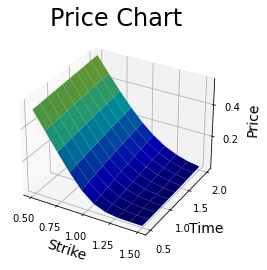

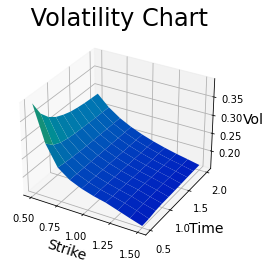

In [55]:
generatePriceChart(StrikesMeshgrid, TimesMeshgrid, PricesMatrix, PricesChartPath)
generateImpliedVolatilityChart(StrikesMeshgrid, TimesMeshgrid, VolatilityMatrix, VolatilityChartPath)